In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
max_limit = 6
budget_diff_penalizer = 1


def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data, data2, data3, data4):
    results = {}
    
    for case_id, case_data in data.items():
        n_qubits = case_data["hyperparams"]["n_qubits"]
        cont_sol = data3[case_id]["continuous_variables_solution"]
        exact_sol = data4[case_id]["exact_solution"]
        qaoa_sol = case_data["qaoa_solution"]
        budget = case_data["hyperparams"]["budget"]
        un_cont_sol = data2[case_id]["continuous_variables_solution_unconstrained"]
        
        allocation2 = un_cont_sol["allocation"]
        used_budget = 0
        for stock, weight in allocation2.items():
            used_budget += weight * data2[case_id]["hyperparams"]["prices_now"][stock]
        unconstrained_cont_value = un_cont_sol["value"]
        unconstrained_cont_penalty = budget_diff_penalizer*un_cont_sol["left_overs"]
        
        cont_value = cont_sol["value"]
        cont_penalty = budget_diff_penalizer*cont_sol["left_overs"]

        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_value = exact_budgets.get("objective_value", 0)
        exact_penalty = budget_diff_penalizer*exact_budgets["difference"]

        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = budget_diff_penalizer*qaoa_budgets["difference"]

        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty},
            "continuous_unconstrained": {"value": unconstrained_cont_value, "penalty": unconstrained_cont_penalty},
            "exact": {"value": exact_value, "penalty": exact_penalty},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty},
            "n_qubits": n_qubits,
            "budget": budget
        }
    
    return results


def plot_objective_vs_budget(results, save_path=None, dpi=300, fig_height=7):
    """
    Creates a publication-quality scatter plot comparing objective values vs budget utilization,
    with a magnified inset showing the upper right corner.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the results for each case and method.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    dpi : int, optional
        Resolution of the saved figure in dots per inch.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed.
    """
    fig_width = 1.618 * fig_height  # Golden ratio for figure width
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 16,
        'axes.linewidth': 0.8,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set smoke gray background for plotting area
    ax.set_facecolor('#f0f0f0')  # Light smoke gray
    
    # Define a professional color palette (colorblind-friendly)
    colors = ['#0173B2', '#DE8F05', '#029E73']
    markers = ['o', 's', '^', 'P', 'D']
    
    # Extract data for plotting
    continuous_obj_values = []
    exact_obj_values = []
    qaoa_obj_values = []
    unconstrained_obj_values = []
    
    continuous_budget_pct = []
    exact_budget_pct = []
    qaoa_budget_pct = []
    unconstrained_budget_pct = []
    
    case_labels = []
    
    # Process data for plotting
    for case_id, case_data in results.items():
        case_labels.append(case_id)

        vals = [case_data["continuous"]["value"], case_data["exact"]["value"], case_data["qaoa"]["value"], case_data["continuous_unconstrained"]["value"]]
        max_val = max(vals)
        min_val = min(vals)
        obj_range = max_val - min_val
        # Normalize objective values to [0,1] scale
        cont_obj = (case_data["continuous"]["value"] - min_val)/obj_range
        exact_obj = (case_data["exact"]["value"]- min_val)/obj_range
        qaoa_obj = (case_data["qaoa"]["value"]- min_val)/obj_range
        unconstrained_cont_obj = (case_data["continuous_unconstrained"]["value"]- min_val)/obj_range
        
        if case_id == "47":
            print(f"Case {case_id} - cont_obj: {case_data['continuous']['value']}, exact_obj: {case_data['exact']['value']}, qaoa_obj: {case_data['qaoa']['value']}, unconstrained_cont_obj: {case_data['continuous_unconstrained']['value']}")

        continuous_obj_values.append(cont_obj)
        exact_obj_values.append(exact_obj)
        qaoa_obj_values.append(qaoa_obj)
        unconstrained_obj_values.append(unconstrained_cont_obj)
        
        # Calculate budget utilization percentage
        budget = case_data["budget"]
        cont_budget_pct = 100 - case_data["continuous"]["penalty"] / budget * 100
        ex_budget_pct = 100 - case_data["exact"]["penalty"] / budget * 100
        q_budget_pct = 100 - case_data["qaoa"]["penalty"] / budget * 100
        u_budget_pct = 100 - case_data["continuous_unconstrained"]["penalty"] / budget * 100
        
        continuous_budget_pct.append(cont_budget_pct)
        exact_budget_pct.append(ex_budget_pct)
        qaoa_budget_pct.append(q_budget_pct)
        unconstrained_budget_pct.append(u_budget_pct)
    
    # Plot scatter points
    cont_scatter = ax.scatter(continuous_obj_values, continuous_budget_pct, 
                             label="Continuous constrained + discretization", 
                             color=colors[0], marker=markers[0], s=80, 
                             edgecolor='black', linewidth=0.5, alpha=0.8)
    
    unconstrained_scatter = ax.scatter(unconstrained_obj_values, unconstrained_budget_pct, 
                                       label="Continuous unconstrained + discretization", 
                                       color='gray', marker=markers[3], s=80, 
                                       edgecolor='black', linewidth=0.5, alpha=0.8)
    
    exact_scatter = ax.scatter(exact_obj_values, exact_budget_pct, 
                              label="Eigensolver solution to HUBO", 
                              color=colors[1], marker=markers[1], s=80, 
                              edgecolor='black', linewidth=0.5, alpha=0.8)
    
    qaoa_scatter = ax.scatter(qaoa_obj_values, qaoa_budget_pct, 
                             label="QAOA solution to HUBO", 
                             color=colors[2], marker=markers[2], s=80, 
                             edgecolor='black', linewidth=0.5, alpha=0.8)
    
    # Add optimal region highlighting - high objective value and good budget utilization
    #ax.axhspan(95, 105, alpha=0.1, color='green', zorder=0)
    #ax.axvspan(0.95, 1.0, alpha=0.1, color='green', zorder=0)
    
    # Add text labels for cases
    for i, case in enumerate(case_labels):
        font_size = 9
        ax.annotate(case, (continuous_obj_values[i], continuous_budget_pct[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=font_size)
        ax.annotate(case, (exact_obj_values[i], exact_budget_pct[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=font_size)
        ax.annotate(case, (qaoa_obj_values[i], qaoa_budget_pct[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=font_size)
        ax.annotate(case, (unconstrained_obj_values[i], unconstrained_budget_pct[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=font_size)
    
    # Add reference lines
    ax.axhline(y=100, color='black', linestyle='--', alpha=0.3, zorder=0)
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.3, zorder=0)
    
    # Customize axes
    ax.set_xlabel("Normalized objective value without budget constraint (higher is better)", fontweight='bold')
    ax.set_ylabel("Budget Utilization (%)", fontweight='bold')
    
    # Set axis limits with some padding
    min_obj = min(min(continuous_obj_values), min(exact_obj_values), min(qaoa_obj_values), min(unconstrained_obj_values))
    max_obj = max(max(continuous_obj_values), max(exact_obj_values), max(qaoa_obj_values), max(unconstrained_obj_values))
    obj_margin = (max_obj - min_obj) * 0.1
    ax.set_xlim(min_obj - obj_margin, max_obj + obj_margin)

    min_budget = min(min(continuous_budget_pct), min(exact_budget_pct), min(qaoa_budget_pct), min(unconstrained_budget_pct))
    max_budget = max(max(continuous_budget_pct), max(exact_budget_pct), max(qaoa_budget_pct), max(unconstrained_budget_pct))
    budget_margin = (max_budget - min_budget) * 0.1
    ax.set_ylim(min_budget - budget_margin, max_budget + budget_margin)
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend in optimal position
    ax.legend(loc='lower right', ncol=1)
    
    if True:
    # Create an inset for the magnified view of the upper right corner
    # Determine zoom region boundaries (focus on the upper right corner)
        zoom_x_min = 0.97  # Adjust as needed based on your data
        zoom_x_max = 1.02
        zoom_y_min = 97    # Adjust as needed based on your data
        zoom_y_max = 99.5
        
        # Create the zoomed inset axes (position relative to main axes)
        axins = zoomed_inset_axes(ax, 6, 
                          bbox_to_anchor=(0.5, 0.5), 
                          bbox_transform=ax.transAxes) # zoom factor: 4, location: lower right
        
        # Plot the same data in the inset
        axins.scatter(continuous_obj_values, continuous_budget_pct, 
                    color=colors[0], marker=markers[0], s=60, 
                    edgecolor='black', linewidth=0.5, alpha=0.8)
        
        axins.scatter(exact_obj_values, exact_budget_pct, 
                    color=colors[1], marker=markers[1], s=60, 
                    edgecolor='black', linewidth=0.5, alpha=0.8)
        
        axins.scatter(qaoa_obj_values, qaoa_budget_pct, 
                    color=colors[2], marker=markers[2], s=60, 
                    edgecolor='black', linewidth=0.5, alpha=0.8)
        
        axins.scatter(unconstrained_obj_values, unconstrained_budget_pct, 
                    color='gray', marker=markers[3], s=60, 
                    edgecolor='black', linewidth=0.5, alpha=0.8)
        
        # Add text labels in the inset too, but only for points in the zoom region
        for i, case in enumerate(case_labels):
            # Only add labels for points actually in the zoomed region
            font_size = 8
            if (zoom_x_min <= continuous_obj_values[i] <= zoom_x_max and 
                zoom_y_min <= continuous_budget_pct[i] <= zoom_y_max):
                axins.annotate(case, (continuous_obj_values[i], continuous_budget_pct[i]),
                            xytext=(3, 3), textcoords='offset points', fontsize=font_size)
            
            if (zoom_x_min <= exact_obj_values[i] <= zoom_x_max and 
                zoom_y_min <= exact_budget_pct[i] <= zoom_y_max):
                axins.annotate(case, (exact_obj_values[i], exact_budget_pct[i]),
                            xytext=(3, 3), textcoords='offset points', fontsize=font_size)
            
            if (zoom_x_min <= qaoa_obj_values[i] <= zoom_x_max and 
                zoom_y_min <= qaoa_budget_pct[i] <= zoom_y_max):
                axins.annotate(case, (qaoa_obj_values[i], qaoa_budget_pct[i]),
                            xytext=(3, 3), textcoords='offset points', fontsize=font_size)
            
            if (zoom_x_min <= unconstrained_obj_values[i] <= zoom_x_max and 
                zoom_y_min <= unconstrained_budget_pct[i] <= zoom_y_max):
                axins.annotate(case, (unconstrained_obj_values[i], unconstrained_budget_pct[i]),
                            xytext=(3, 3), textcoords='offset points', fontsize=font_size)
    
        # Set the limits for the inset axes
        axins.set_xlim(zoom_x_min, zoom_x_max)
        axins.set_ylim(zoom_y_min, zoom_y_max)
        
        # Add grid to inset
        axins.grid(True, linestyle='--', alpha=0.7, zorder=0)
        
        # Remove ticks and ticklabels from inset to make it cleaner
        axins.tick_params(axis='both', which='both', labelsize=8)
        
        # Draw connecting lines between the main axes and the inset
        mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
    
    # Adjust layout
    #plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

Loaded 100 cases.


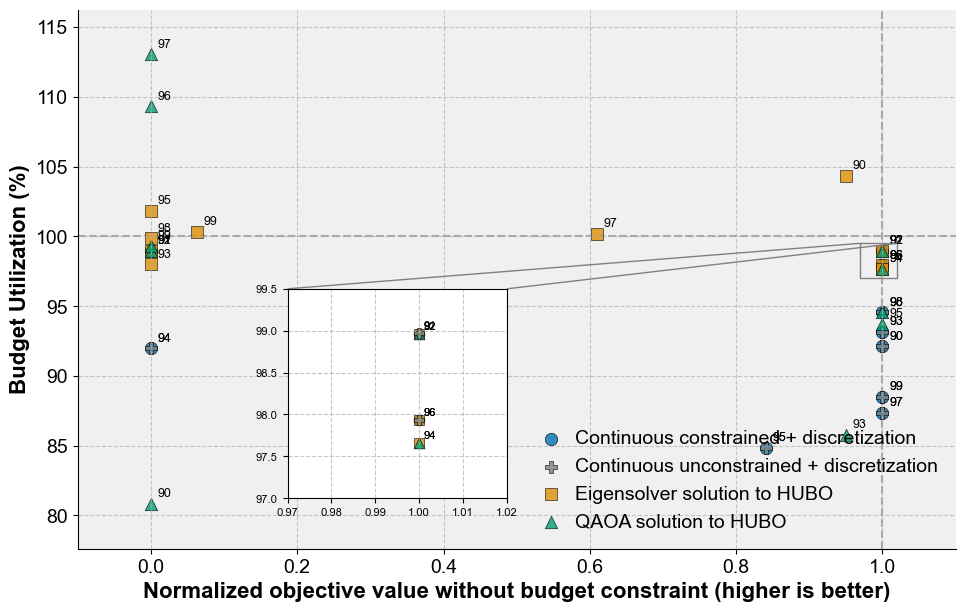

In [ ]:
def main():
    data = {}
    # Get file names like portfolio_optimization_results_batch_ from the parent directory
    method = "cmaes"
    files = [file for file in os.listdir(f"../results/{method}_hubo_results") if "portfolio_optimization_results_batch_" in file]
    for file in files:
        data.update(load_json(f"../results/{method}_hubo_results/" + file))
    
    data2 = load_json("../results/classical_unconstrained/filtered_portfolio_optimization_results.json")
    data3 = load_json("../results/classical_constrained/filtered_portfolio_optimization_results.json")
    data4 = load_json("../results/exact_eigensolver/filtered_portfolio_optimization_results.json")
    
    print(f"Loaded {len(data)} cases.")
    nqubits = 6
    path = f"./{nqubits}_qubits"
    results = compare_solutions(data, data2, data3, data4)
    
    subset_of_results = {}
    for key in list(results.keys()):
        n_qubits = results[key]["n_qubits"]
        if n_qubits == nqubits:
            subset_of_results[key] = results[key]
    
    # Use the new plotting function
    fig, ax = plot_objective_vs_budget(subset_of_results, save_path=path + "_obj_vs_budget.png")
    
    # Also keep the original plot for comparison
    #plot_scores(subset_of_results, save_path=path)
    return data

data = main()